## Taller-01

- Implementar un modelo de clasificación para predecir la enfermedad de las hojas de mango
- Crear un vector de caracteristicas HOG (Histográma de Gradientes Orientados).
- Usar el modelo de clasificación de su preferencia (Redes Neuronales, Árboles, KNN, SVM)
- Evaluar (Acc - F1 Score)

## Implementacion usando SVM

In [7]:
# Import the necessary libraries
import os
import cv2
import json
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

In [8]:
# install gdown para descargar el dataset de google drive
!pip install gdown

In [13]:
# Descarga el dataset de Google Drive
import gdown
file_id = "1KXWbGMu3Kiv9ghg-BWRA3z3Uvb0q4gXr"
destination = "dataset.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1KXWbGMu3Kiv9ghg-BWRA3z3Uvb0q4gXr
From (redirected): https://drive.google.com/uc?id=1KXWbGMu3Kiv9ghg-BWRA3z3Uvb0q4gXr&confirm=t&uuid=f7313b94-315c-4539-ba70-b62818992e6d
To: /Users/cristianblandon/projects/NoHelmetNet/Talleres/Taller01-clasificacion/notebooks/dataset.zip
100%|██████████| 110M/110M [00:10<00:00, 10.9MB/s] 


'dataset.zip'

In [14]:
# Descomprime el dataset
if not os.path.exists("../data"):
    os.system("unzip dataset.zip -d ../data")

Archive:  dataset.zip
   creating: /Users/cristianblandon/projects/NoHelmetNet/Talleres/Taller01-clasificacion/data/mango_leaf_disease
  inflating: ../data/__MACOSX/._mango_leaf_disease  
   creating: /Users/cristianblandon/projects/NoHelmetNet/Talleres/Taller01-clasificacion/data/mango_leaf_disease/Bacterial Canker
  inflating: ../data/__MACOSX/mango_leaf_disease/._Bacterial Canker  
   creating: /Users/cristianblandon/projects/NoHelmetNet/Talleres/Taller01-clasificacion/data/mango_leaf_disease/Anthracnose
  inflating: ../data/__MACOSX/mango_leaf_disease/._Anthracnose  
   creating: /Users/cristianblandon/projects/NoHelmetNet/Talleres/Taller01-clasificacion/data/mango_leaf_disease/Healthy
  inflating: ../data/__MACOSX/mango_leaf_disease/._Healthy  
   creating: /Users/cristianblandon/projects/NoHelmetNet/Talleres/Taller01-clasificacion/data/mango_leaf_disease/Powdery Mildew
  inflating: ../data/__MACOSX/mango_leaf_disease/._Powdery Mildew  
   creating: /Users/cristianblandon/projects


  inflating: ../data/__MACOSX/mango_leaf_disease/Gall Midge/._IMG_20211106_164434 (Custom).jpg  
  inflating: ../data/mango_leaf_disease/Gall Midge/IMG_20211106_164543 (Custom).jpg  
  inflating: ../data/__MACOSX/mango_leaf_disease/Gall Midge/._IMG_20211106_164543 (Custom).jpg  
  inflating: ../data/mango_leaf_disease/Gall Midge/IMG_20211106_161336 (Custom).jpg  
  inflating: ../data/__MACOSX/mango_leaf_disease/Gall Midge/._IMG_20211106_161336 (Custom).jpg  
  inflating: ../data/mango_leaf_disease/Gall Midge/IMG_20211106_163210 (Custom).jpg  
  inflating: ../data/__MACOSX/mango_leaf_disease/Gall Midge/._IMG_20211106_163210 (Custom).jpg  
  inflating: ../data/mango_leaf_disease/Gall Midge/IMG_20211106_162143 (Custom).jpg  
  inflating: ../data/__MACOSX/mango_leaf_disease/Gall Midge/._IMG_20211106_162143 (Custom).jpg  
  inflating: ../data/mango_leaf_disease/Gall Midge/IMG_20211106_165803 (Custom).jpg  
  inflating: ../data/__MACOSX/mango_leaf_disease/Gall Midge/._IMG_20211106_165803 (C

In [18]:
dataset_dir = "../data/mango_leaf_disease"
images = []
labels = []

# Iterar sobre cada subcarpeta dentro del dataset
for label in os.listdir(dataset_dir):
    label_path = os.path.join(dataset_dir, label)
    # Validar que sea una carpeta
    if os.path.isdir(label_path):
        # Iterar sobre cada imagen en la carpeta
        for file in os.listdir(label_path):
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(label_path, file)
                # Cargar la imagen en escala de grises
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(img)
                    labels.append(label)
                else:
                    print(f"Unable to read image: {img_path}")

print(f"Total images loaded: {len(images)}")
print(f"Total labels loaded: {len(labels)}")

Total images loaded: 4000
Total labels loaded: 4000


In [19]:
# Validamos si el dataset está balanceado
label_counts = Counter(labels)
print("Distribución de clases:", label_counts)

# Convertir Counter a diccionario y formatearlo con indentación
formatted_counts = json.dumps(dict(label_counts), indent=4)
print("Distribución de clases (formateado en JSON):")
print(formatted_counts)

Distribución de clases: Counter({'Bacterial Canker': 500, 'Anthracnose': 500, 'Healthy': 500, 'Powdery Mildew': 500, 'Cutting Weevil': 500, 'Die Back': 500, 'Sooty Mould': 500, 'Gall Midge': 500})
Distribución de clases (formateado en JSON):
{
    "Bacterial Canker": 500,
    "Anthracnose": 500,
    "Healthy": 500,
    "Powdery Mildew": 500,
    "Cutting Weevil": 500,
    "Die Back": 500,
    "Sooty Mould": 500,
    "Gall Midge": 500
}


In [20]:
# Función para extraer características HOG
def extract_hog_features(image):
    hog = cv2.HOGDescriptor()
    # Redimensionar la imagen al tamaño de la ventana por defecto del HOGDescriptor (64x128)
    image_resized = cv2.resize(image, hog.winSize)
    return hog.compute(image_resized).flatten()

In [21]:
# Extraer las características HOG de todas las imágenes
hog_features = [extract_hog_features(image) for image in images]

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)

In [22]:
# Crear y entrenar el modelo SVM
svm_model = SVC(kernel='linear', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [23]:
# Realizar predicciones
y_pred = svm_model.predict(X_test)

In [24]:
# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Accuracy: 0.7875
F1 Score: 0.7886677223349428


## Aplicando MLP Classifier

In [25]:
# Crear y entrenar el modelo de Red Neuronal
from sklearn.neural_network import MLPClassifier

# Puedes ajustar los hiperparámetros según las características de tus datos
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', 
                          max_iter=300, random_state=42)
mlp_model.fit(X_train, y_train)

# Realizar predicciones
y_pred_nn = mlp_model.predict(X_test)

# Evaluar el modelo
accuracy_nn = accuracy_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn, average='weighted')

print(f"Neural Network Accuracy: {accuracy_nn}")
print(f"Neural Network F1 Score: {f1_nn}")

Neural Network Accuracy: 0.7725
Neural Network F1 Score: 0.7726598677502924


## Red Neuronal usando ResNet50

In [26]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

In [27]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [28]:
# Función para preparar la imagen para ResNet50:
def prepare_image(img):
    # Si la imagen es escala de grises, conviértela a 3 canales
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    # Redimensionar a 224x224
    img_resized = cv2.resize(img, (224, 224))
    # Convertir a array y preprocesar
    img_array = img_to_array(img_resized)
    img_preprocessed = preprocess_input(img_array)
    return img_preprocessed

In [29]:
# Preparar el dataset: procesar cada imagen
prepared_images = [prepare_image(image) for image in images]
X = np.array(prepared_images)

In [30]:
# Convertir etiquetas a formato numérico y one-hot encoding
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(labels)
y = to_categorical(y_encoded)

In [31]:
# Dividir los datos en entrenamiento y prueba (usando stratify para mantener la distribución de clases)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [32]:
# Construir el modelo con ResNet50 como base (sin la capa top) y una capa densa final para la clasificación
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(y.shape[1], activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Congelar las capas de la base para aprovechar la transferencia de aprendizaje
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2025-06-02 11:18:33.240194: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-06-02 11:18:33.240409: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-06-02 11:18:33.240423: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-06-02 11:18:33.240468: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-02 11:18:33.240481: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [33]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5


2025-06-02 11:18:41.685115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 204ms/step - accuracy: 0.7163 - loss: 0.8753 - val_accuracy: 0.9762 - val_loss: 0.1242
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - accuracy: 0.9874 - loss: 0.0835 - val_accuracy: 0.9825 - val_loss: 0.0760
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - accuracy: 0.9932 - loss: 0.0431 - val_accuracy: 0.9875 - val_loss: 0.0577
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 181ms/step - accuracy: 0.9959 - loss: 0.0312 - val_accuracy: 0.9887 - val_loss: 0.0466
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - accuracy: 0.9988 - loss: 0.0218 - val_accuracy: 0.9875 - val_loss: 0.0458


In [34]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print("ResNet Model Loss:", loss)
print("ResNet Model Accuracy:", accuracy)



25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9914 - loss: 0.0353
ResNet Model Loss: 0.04583662003278732
ResNet Model Accuracy: 0.987500011920929


In [35]:
import numpy as np
from sklearn.metrics import f1_score

# Obtener las predicciones en forma de probabilidades
y_pred_probs = model.predict(X_test)
# Convertir las predicciones a etiquetas (índices)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
# Convertir las etiquetas verdaderas (one-hot) a índices
y_true_labels = np.argmax(y_test, axis=1)

# Calcular el F1 Score ponderado
resnet_f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
print("ResNet F1 Score:", resnet_f1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step
ResNet F1 Score: 0.9874639803563388


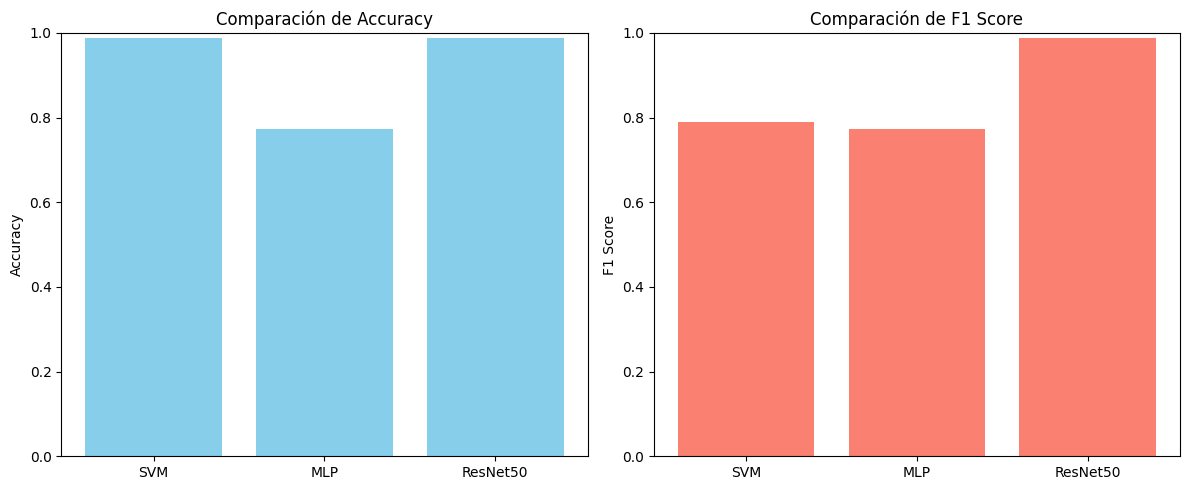

In [36]:
# Crea una gráfica para comparar Accuracy y F1 Score de SVM, MLP y ResNet50

import matplotlib.pyplot as plt

# Se asume que estos resultados se han calculado anteriormente:
# SVM:
svm_accuracy = accuracy         # Accuracy del SVM (ya calculado)
svm_f1 = f1                     # F1 Score del SVM

# MLP:
mlp_accuracy = accuracy_nn       # Accuracy del MLP
mlp_f1 = f1_nn                   # F1 Score del MLP

# ResNet50:
# Para evitar colisiones con la variable 'accuracy' de SVM, se recomienda renombrar al evaluar ResNet:
resnet_accuracy = accuracy  # Reemplazar con el valor obtenido tras la evaluación de ResNet50
resnet_f1 = resnet_f1      # Reemplazar con el valor de F1 Score de ResNet50, si se calcula

models = ['SVM', 'MLP', 'ResNet50']
accuracies = [svm_accuracy, mlp_accuracy, resnet_accuracy]
f1_scores = [svm_f1, mlp_f1, resnet_f1]

plt.figure(figsize=(12, 5))

# Gráfica de Accuracy
plt.subplot(1, 2, 1)
plt.bar(models, accuracies, color='skyblue')
plt.ylim(0, 1)
plt.title('Comparación de Accuracy')
plt.ylabel('Accuracy')

# Gráfica de F1 Score
plt.subplot(1, 2, 2)
plt.bar(models, f1_scores, color='salmon')
plt.ylim(0, 1)
plt.title('Comparación de F1 Score')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()